**med-prj2-param-jnb.ipynb**: Jupyter notebook template provided in support of the course *Modeling of Earth System Data* (Fall 2022, course instructor: Joachim Vogt).

# Parametric Modeling of Earth System Processes

In this project, key concepts presented in the course chapter *Parametric Modeling of Earth System Processes* are to be demonstrated using a combined polynomial and harmonic regression model applied to climate time series showing periodicities, namely, time series of the Quasi-Biennial Oscillation (QBO) as well as monthly mean values of globally averaged CO$_2$ concentrations as provided by NOAA/GML.

Imports: NumPy, matplotlib.pyplot, scipy.stats.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

## Preparation

Consult the presentation file of the course chapter *Parametric Modeling of Earth System Processes* to review the theoretical basis of linear parametric modeling. Go through the computational exercises to recall the numerical methodology and the syntax of relevant Python functions. Of particular importance is the Numerical Software Lab (Jupyter notebook) associated with the section *Data modeling and numerical linear algebra*, where a harmonic regression model is applied to the QBO data (file [qbo.dat](https://www.geo.fu-berlin.de/met/ag/strat/produkte/qbo/qbo.dat) provided by the Institute of Meteorology at the FU Berlin through their website [The Quasi-Biennial Oscillation (QBO) Data Series](https://www.geo.fu-berlin.de/en/met/ag/strat/produkte/qbo/index.html). Familiarize with the scientific context and the data format.

Visit the web archive on [Carbon Cycle Greenhouse Gases](https://gml.noaa.gov/ccgg/) hosted by the [Global Monitoring Laboratory (GML)](https://gml.noaa.gov/) at the US National Oceanic and Atmospheric Administration (NOAA). [Globally averaged marine surface monthly mean data](https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_gl.txt) of CO$_2$ concentrations are available from the web page [Trends in Atmospheric Carbon Dioxide](https://gml.noaa.gov/ccgg/trends/gl_data.html) maintained by [Ed Dlugokencky and Pieter Tans, NOAA/GML](https://gml.noaa.gov/ccgg/trends/).

## Implementation and test of the model function

The function used to model the data $d = d(t)$ combines a polynomial fit with harmonic regression:
$$
m(t) 
\; = \;
\sum_{j=0}^{D} a_j t^j
\, + \,
\sum_{k=1}^{L} \left\{
a_{2k+1} \cos \left( 2 \pi k f t \right) 
\, + \, a_{2k+2} \sin \left( 2 \pi k f t \right) 
\right\} ~.
$$
Here $D$ denotes the degree of the polynomial, and $L$ is number of harmonics considered in the function.

The model function is implemented in the cell below. Check the code to understand its logic and syntax. In addition to the model parameter vector $\mathbf{a} = (a_0,a_1,\ldots)^\mathsf{T}$, the function is supposed to return the prediction $m(t)$ and the root-mean-square (RMS) misfit 
$$
\text{RMSmf} 
\; = \; \sqrt{ \left\langle [ d(t) - m(t) ]^2 \right\rangle_t }
$$
where $\langle \cdots \rangle_t$ denotes (time) averaging. Error weighting is disregarded for the purpose of the current project. The RMS misfit calculated this way suggests that the model captures the essential process(es) generating the data if its numerical value is comparable with the measurement accuracy (standard error of a single datum).

In [2]:
def FitPolyHarm(Time,Data,Freq,DPoly=0,LHarm=1):
    '''
    FIT the POLYnomial-plus-HARMonic model function:
      m(t) = sum_{j=0}^D a[j]*t**j
             sum_{k=1}^L ( a[2*k+1]*cos(2*pi*k*f*t) + a[2k+2]*sin(2*pi*k*f*t )
    using the least-squares normal equations.
    Input:
      Time  : array of t(ime) values
      Data  : array of d(ata) values
      Freq  : frequency f
      DPoly : polynomical degree (parameter D)
      LHarm : number of harmonics (parameter L)
    Output:
      Aest  : amplitude vector
      Pred  : model prediction
      RMSmf : root-mean-square misfit (1+D+2L parameters)
    '''
    import numpy as np
    NData = len(Data)
    #.. initialize model matrix with basis function f0
    M = np.ones(NData)[:,None]
    #.. add polynomial basis functions to the model matrix
    for j in range(1,DPoly+1):
        BasFunPoly = (Time**j)[:,None]
        M = np.concatenate((M,BasFunPoly),axis=-1)
    ot = 2*np.pi*Freq*Time
    #.. add harmonic basis functions to the model matrix
    for k in range(1,LHarm+1):
        BasFunCos = np.cos(k*ot)[:,None]
        BasFunSin = np.sin(k*ot)[:,None]
        M = np.concatenate((M,BasFunCos,BasFunSin),axis=-1)
    #.. get parameters using the least squares normal equations
    Aest = np.linalg.solve(M.T@M,M.T@Data)
    #.. model prediction
    Pred = M.dot(Aest)
    #.. RMS misfit
    RMSmf = np.sqrt( np.sum( (Data-Pred)**2 ) / (NData-1-DPoly-2*LHarm) )
    return Aest,Pred,RMSmf

Test the function ``FitPolyHarm()`` using the synthetic data example from the Jupyter notebook *Data modeling and numerical linear algebra*. Note that for default values of the keyword arguments ``DPoly`` and ``NHarm``, the function can be called in the same way as the function ``harmoreg()`` from that notebook.

Parameters :  [-3.08951672  5.30641702 -2.27812486]
RMS misfit :  2.185209281851459


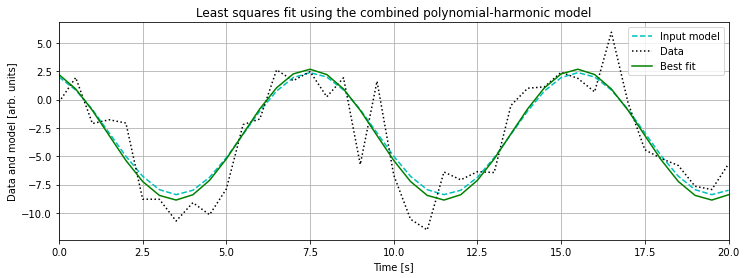

In [115]:
#.. set configuration parameters
NData = 41      #.. number of elements in time series
dt = 0.5        #.. sampling interval
Freq = 0.125    #.. frequency
Sigma = 2.0     #.. noise level
#.. choose input model parameters (amplitudes)
A0 = -3.0       #.. coefficient a0
A1 = 5.0        #.. coefficient a1
A2 = -2.0       #.. coefficient a2
#.. construct synthetic time series
Time = dt*np.linspace(0,NData-1,NData)
ot = 2*np.pi*Freq*Time
InpMod = A0 + A1*np.cos(ot) + A2*np.sin(ot)
Data = InpMod + Sigma*np.random.randn(NData)
#.. estimatate model parameters from the data 
Aest,Pred,RMSmf = FitPolyHarm(Time,Data,Freq)
print('Parameters : ',Aest)
print('RMS misfit : ',RMSmf)
#.. plot data and model
plt.figure(figsize=(12,4))
plt.plot(Time,InpMod,'c--',label='Input model')
plt.plot(Time,Data,'k:',label='Data')
plt.plot(Time,Pred,'g-',label='Best fit')
plt.title('Least squares fit using the combined polynomial-harmonic model')
plt.xlabel('Time [s]')
plt.ylabel('Data and model [arb. units]')
plt.xlim([0,(NData-1)*dt])
plt.legend()
plt.grid()

Repeat the test of the function ``FitPolyHarm()`` using synthetic data produced from a model function that combines a polynomical of degree $D=1$ with and a harmonic function involving $L=2$ cosine and sine terms.

Parameters :  [-1.45374072  1.07409894 -2.53980296  0.96497568  0.47958161  0.46460904]
RMS misfit :  2.3509645136484556


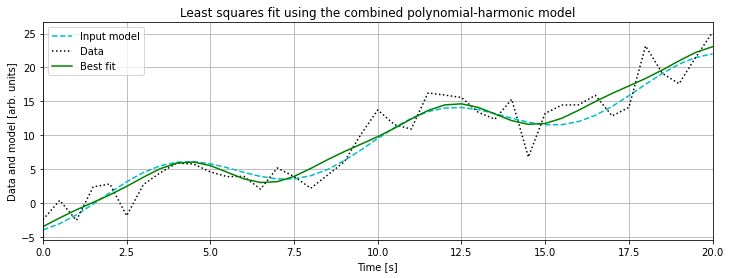

In [116]:
#.. set configuration parameters
Ndata = 41      #.. number of elements in time series
dt = 0.5        #.. sampling interval
Freq = 0.125    #.. frequency
Sigma = 2.0     #.. noise level
#.. choose input model parameters (amplitudes)
A0 = -3.0       #.. coefficient a0
A1 = 1.0        #.. coefficient a1
A2 = 2.0        #.. coefficient a2
A3 = -3.0       #.. coefficient a3
A4 = 0.5        #.. coefficient a4
A5 = 0.5        #.. coefficient a5
#.. construct synthetic time series
Time = dt*np.linspace(0,NData-1,NData)
ot = 2*np.pi*Freq*Time
InpMod = np.polyval([A1,A0],Time) + A2 + A3*np.cos(ot) + A4*np.sin(ot)
Data = InpMod + Sigma*np.random.randn(NData)
#.. estimatate model parameters from the data
Aest,Pred,RMSmf = FitPolyHarm(Time,Data,Freq,1,2)
print('Parameters : ',Aest)
print('RMS misfit : ',RMSmf)
#.. plot data and model
plt.figure(figsize=(12,4))
plt.plot(Time,InpMod,'c--',label='Input model')
plt.plot(Time,Data,'k:',label='Data')
plt.plot(Time,Pred,'g-',label='Best fit')
plt.title('Least squares fit using the combined polynomial-harmonic model')
plt.xlabel('Time [s]')
plt.ylabel('Data and model [arb. units]')
plt.xlim([0,(NData-1)*dt])
plt.legend()
plt.grid()

## QBO time series

Load the QBO time series as in the Jupyter notebook *Data modeling and numerical linear algebra*.

In [117]:
#.. open and read data file
DataFolder = './'
with open(DataFolder+'qbo.dat','r') as f:
    qbodat = f.readlines()
#.. extract year, month, and wind speeds at three pressure levels
year = np.asarray([line[6:8] for line in qbodat[33:]],dtype=float)
month = np.asarray([line[8:10] for line in qbodat[33:]],dtype=float)
u70 = 0.1*np.asarray([line[12:16] for line in qbodat[33:]],dtype=float)
u50 = 0.1*np.asarray([line[19:23] for line in qbodat[33:]],dtype=float)
u30 = 0.1*np.asarray([line[33:37] for line in qbodat[33:]],dtype=float)
#.. fractional year
Time = np.where(year < 50, 2000+year, 1900+year)
Time = Time-1/24+month/12
#.. select pressure level
Data = u30; hPa='30'
#---Data = u50; hPa='50'
#---Data = u70; hPa='70'

Set the QBO period to 28.2 months and call ``FitPolyHarm()`` with $L=1,2,3,4,5$ harmonics to obtain fits for different model orders $L$. Plot the RMS misfit versus the number of harmonics $L$. The curve starts to flatten at $L=1$ which means that the mean square deviation is not reduced further by considering more than just the first harmonic. Inspect the corresponding numerical value of the RMS misfit. Since the input data are given in units of 0.1 m/s, you may assume that the measurement uncertainty is below 1 m/s.

Number of harmonics = 0, RMS misfit = 18.05769635516784
Number of harmonics = 1, RMS misfit = 14.213963728299232
Number of harmonics = 2, RMS misfit = 14.217839128510063
Number of harmonics = 3, RMS misfit = 14.229907489160098
Number of harmonics = 4, RMS misfit = 14.2333496670645
Number of harmonics = 5, RMS misfit = 14.248924481731722


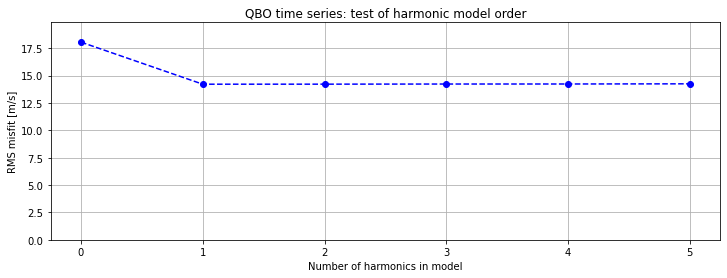

In [118]:
#.. QBO parameters
PeriodQBO = 28.2
FreqQBO = 12/PeriodQBO
#.. number of harmonics to be tested
LHarmMax = 5
#.. initialize RMS misfit array
RMSmf = np.zeros(LHarmMax+1)
#.. estimate model parameters and predictions
for k in range(LHarmMax+1):
    Aest,Pred,RMSmf[k] = FitPolyHarm(Time,Data,FreqQBO,0,k)
    print('Number of harmonics = {k:1}, RMS misfit = {r}'.format(k=k,r=RMSmf[k]) )
#.. create plot of RMS misfits
plt.figure(figsize=(12,4))
plt.plot(RMSmf,'b--')
plt.plot(RMSmf,'bo')
plt.title('QBO time series: test of harmonic model order')
plt.xlabel('Number of harmonics in model')
plt.ylim([0,RMSmf.max()*1.1])
plt.ylabel('RMS misfit [m/s]')
plt.grid()
#... store figure in graphics file
plt.savefig('qbo_model_comparison.pdf',facecolor=None,bbox_inches='tight')

Compute the least squares model parameters and compute the coefficient of linear correlation between the data and the best fit. Display the data together with the model. Add a second panel with a plot of the residuals.  Discuss how well the model captures the dynamics of the process(es) generating the QBO time series.

Correlation coefficient   :  0.618093017651318


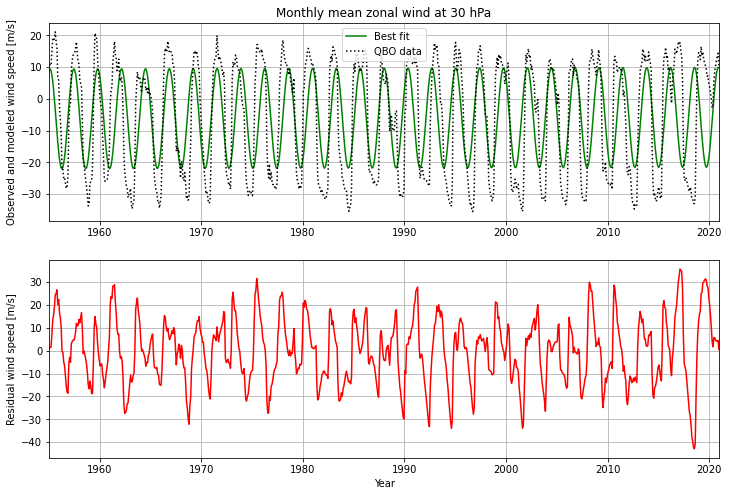

In [119]:
#.. estimate model parameters and predictions
Aest,Pred,RMSmf = FitPolyHarm(Time,Data,FreqQBO,DPoly=1,LHarm=1)
#.. compute and print correlation coefficient
print('Correlation coefficient   : ',np.corrcoef(Pred,Data)[0,1])
#.. open figure object
plt.figure(figsize=(12,8))
#.. subplot showing data and model
plt.subplot(2,1,1)
plt.plot(Time,Pred,'g-',label='Best fit')
plt.plot(Time,Data,'k:',label='QBO data')
plt.xlim(Time.min(),Time.max())
plt.title('Monthly mean zonal wind at '+hPa+' hPa')
plt.ylabel('Observed and modeled wind speed [m/s]')
plt.legend()
plt.grid()
#.. subplot showing residuals
plt.subplot(2,1,2)
plt.plot(Time,Data-Pred,'r')
plt.xlim(Time.min(),Time.max())
plt.xlabel('Year')
plt.ylabel(r'Residual wind speed [m/s]')
plt.grid()
#... store figure in graphics file
plt.savefig('qbo_fitpolyharm.pdf',facecolor=None,bbox_inches='tight')

## Globally averaged marine CO$_2$ concentrations

This part of the data modeling project is concerned with [globally averaged marine surface monthly mean data](https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_gl.txt) of CO$_2$ concentrations from the web page [Trends in Atmospheric Carbon Dioxide](https://gml.noaa.gov/ccgg/trends/gl_data.html) maintained by [Ed Dlugokencky and Pieter Tans, NOAA/GML](https://gml.noaa.gov/ccgg/trends/). Load the CO$_2$ concentrations from the file and set a reference year. Note that data before before that year are disregarded.

In [7]:
#.. load data from file co2_mm_gl.txt
DataFolder = './'
Time,Data = np.genfromtxt(DataFolder+'co2_mm_gl.txt',usecols=(2,3),unpack=True)
RefYear = 1980
sinceRefYear = Time>=RefYear
TimeRY = Time[sinceRefYear] - RefYear
DataRY = Data[sinceRefYear]

CO$_2$ concentrations are affected by the annual vegetation cycle, hence we set the fundamental period of the polynomial-harmonic model to one year. Plot the RMS misfit versus the number of harmonics $L$. At which value of the model order $L$ do you observe the 'knee' of the RMS misfit curve, i.e., where does the curve begin to flatten? Compare the RMS misfit with the measurement error specified in the data file.

Number of harmonics = 0, RMS misfit = 1.654278012928572
Number of harmonics = 1, RMS misfit = 0.8306208965241454
Number of harmonics = 2, RMS misfit = 0.6602865393563011
Number of harmonics = 3, RMS misfit = 0.6547601560174813
Number of harmonics = 4, RMS misfit = 0.6560125610780856
Number of harmonics = 5, RMS misfit = 0.657353897068322


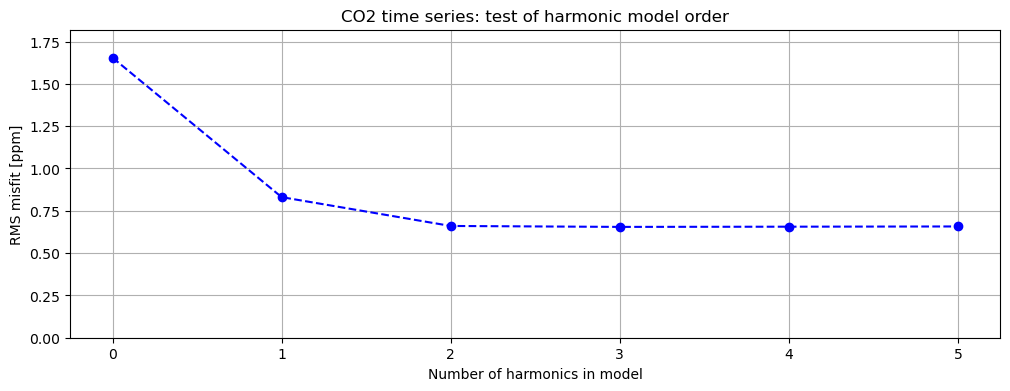

In [8]:
#.. CO2 time series parameters
PeriodCO2 = 1.0
FreqCO2 = 1.0/PeriodCO2
#.. number of harmonics to be tested
LHarmMax = 5
#.. initialize RMS misfit array
RMSmf = np.zeros(LHarmMax+1)
#.. estimate model parameters and predictions
for k in range(LHarmMax+1):
    Aest,Pred,RMSmf[k] = FitPolyHarm(TimeRY,DataRY,FreqCO2,DPoly=2,LHarm=k)
    print('Number of harmonics = {k:1}, RMS misfit = {r}'.format(k=k,r=RMSmf[k]) )
#.. create plot of mean square residuals
plt.figure(figsize=(12,4))
plt.plot(RMSmf,'b--')
plt.plot(RMSmf,'bo')
plt.title('CO2 time series: test of harmonic model order')
plt.xlabel('Number of harmonics in model')
plt.ylim([0,RMSmf.max()*1.1])
plt.ylabel('RMS misfit [ppm]')
plt.grid()
#... store figure in graphics file
plt.savefig('co2gl_model_comparison.pdf',facecolor=None,bbox_inches='tight')

Compute the least squares model parameters and the coefficient of linear correlation between the data and the best fit. Identify the CO$_2$ concentration growth rate $a_1$ in the reference year, and the acceleration parameter $a_2$. Display the data together with the model. Plot also the deseasonalized model, i.e., the polynomial variation only. In a second panel display the residuals. Perform the Shapiro-Wilk normality test and print the probability value.

Correlation coefficient   :  0.9995600750279406
Linear growth rate (1980) :  1.1555728587112093
Acceleration parameter    :  0.01616857454399373
Shapiro-Wilk p-value      :  1.80387349502098e-09
[ 3.38781584e+02  1.15557286e+00  1.61685745e-02  5.58872004e-01
  1.94400084e+00  2.43917197e-01 -6.67814102e-01]


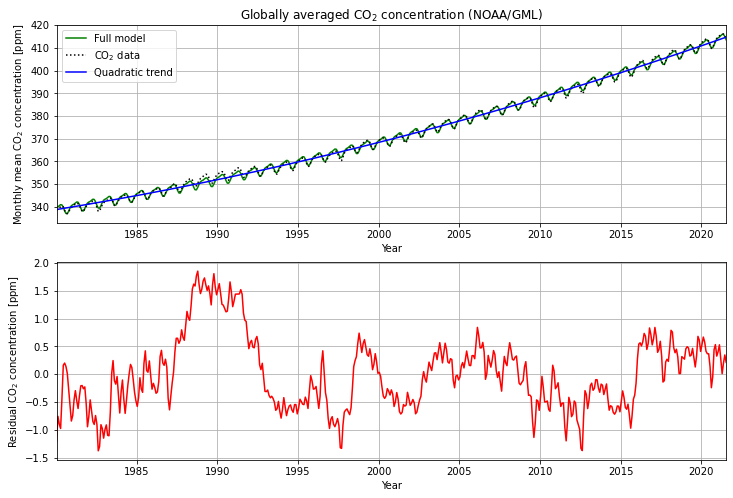

In [122]:
#.. estimate model parameters and predictions
Aest,Pred,RMSmf = FitPolyHarm(TimeRY,DataRY,FreqCO2,DPoly=2,LHarm=2)
#.. compute and print correlation coefficient
print('Correlation coefficient   : ',np.corrcoef(Pred,Data)[0,1])
#.. print model parameters
print('Linear growth rate ({:4}) : '.format(RefYear),Aest[1])
print('Acceleration parameter    : ',Aest[2])
#.. open figure object
plt.figure(figsize=(12,8))
#.. subplot showing data and model
plt.subplot(2,1,1)
plt.plot(Time,Pred,'g-',label='Full model')
plt.plot(Time,Data,'k:',label='CO$_2$ data')
QTrend = np.polyval([Aest[2],Aest[1],Aest[0]],TimeRY)
plt.plot(Time,QTrend,'b-',label='Quadratic trend')
plt.xlim(Time.min(),Time.max())
plt.title(r'Globally averaged CO$_2$ concentration (NOAA/GML)')
plt.xlabel('Year')
plt.ylabel(r'Monthly mean CO$_2$ concentration [ppm]')
plt.legend()
plt.grid()
#.. subplot showing residuals
plt.subplot(2,1,2)
plt.plot(Time,Data-Pred,'r')
plt.xlim(Time.min(),Time.max())
plt.xlabel('Year')
plt.ylabel(r'Residual CO$_2$ concentration [ppm]')
plt.grid()
#... store figure in graphics file
plt.savefig('co2gl_fitpolyharm.pdf',facecolor=None,bbox_inches='tight')
#.. perform Shapiro-Wilk normality test and print probability values
TestStat,ProbVal = stats.shapiro(Data-Pred)
print('Shapiro-Wilk p-value      : ',ProbVal)
print(Aest)

Discuss your findings. Which aspects of the CO$_2$ concentration measurements are captured by the combined polynomial-harmonic model? Which processes are missing?

## Projections of CO$_2$ concentrations

Using the polynomial (quadratric trend) contribution to the CO$_2$ concentration model, the dynamics is to be projected until the mid of the 21st century. The following function applies the bootstrap approach (random resampling with replacement) to generate ensembles of quadratic trend coefficients $a_0,a_1,a_2$.

In [3]:
def QTrendCoeffBS(Time,Data,Freq,LHarm=0,NumSamples=1000):
    '''
    Bootstrap ensembles of quadratic trend coefficients a[0],a[1],a[2] 
    in the quadratic-plus-harmonic model function:
      m(t) = sum_{j=0}^2 a[j]*t**j
             sum_{k=1}^L ( a[2*k+1]*cos(2*pi*k*f*t) + a[2k+2]*sin(2*pi*k*f*t )
    Input:
      Time  : array of t(ime) values
      Data  : array of d(ata) values
      Freq  : frequency f
      LHarm : number of harmonics (parameter L)
    Output:
      Aest0 : bootstrap sample of estimated coefficients a[0]
      Aest1 : bootstrap sample of estimated coefficients a[1]
      Aest2 : bootstrap sample of estimated coefficients a[2]
    '''
    Aest0 = np.zeros(NumSamples)
    Aest1 = np.zeros(NumSamples)
    Aest2 = np.zeros(NumSamples)
    SampleSize = len(Data)
    for isamp in range(NumSamples):
        ind = np.random.choice(SampleSize,SampleSize)
        Aest,Pred,RMSmf = FitPolyHarm(Time[ind],Data[ind],Freq,DPoly=2,LHarm=LHarm)
        Aest0[isamp] = Aest[0]
        Aest1[isamp] = Aest[1]
        Aest2[isamp] = Aest[2]
    return Aest0,Aest1,Aest2

### Tests of the projection prodedure

To demonstrate the projection procedure, let us generate ensembles of models from bootstrap replications of (training) data from the ten-year period 2000-2010. The projections are to be compared with (test) data from the subsequent 10-year period 2010-2020.

In [124]:
RefYear = 2000
indTRN = (Time >= RefYear) & (Time < RefYear+10)
TimeTRN = Time[indTRN] - RefYear
DataTRN = Data[indTRN]
Aest0,Aest1,Aest2 = QTrendCoeffBS(TimeTRN,DataTRN,FreqCO2)
print('Standard deviations : ',Aest0.std(),Aest1.std(),Aest2.std())

Standard deviations :  0.4507552805870505 0.20836973980887233 0.020282871999883392


Display the distributions of the polynomial parameters.

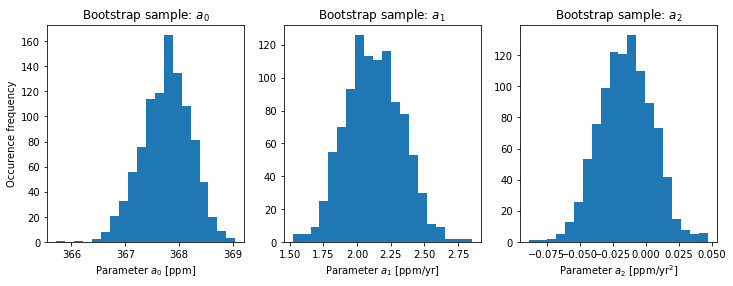

In [125]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(Aest0,20)
plt.title(r'Bootstrap sample: $a_0$')
plt.xlabel(r'Parameter $a_0$ [ppm]')
plt.ylabel('Occurence frequency')
plt.subplot(1,3,2)
plt.hist(Aest1,20)
plt.title(r'Bootstrap sample: $a_1$')
plt.xlabel(r'Parameter $a_1$ [ppm/yr]')
plt.subplot(1,3,3)
plt.hist(Aest2,20)
plt.title(r'Bootstrap sample: $a_2$')
plt.xlabel(r'Parameter $a_2$ [ppm/yr$^2$]')
#... store figure in graphics file
plt.savefig(r'co2gl_qthist_{b:4}-{e:4}.pdf'.format(b=RefYear,e=RefYear+10),\
            facecolor=None,bbox_inches='tight')

The bootstrap ensembles of quadratic trend coefficients give rise to an ensemble of quadratic trend projections stored in ``QTrendCO2`` for the time interval 2000-2020, encompassing both the training period 2000-2010 and the test period 2010-2020. From the quadratic trend projections we extract the percentiles at 0.5% and 99.5%, and also the median (50% percentile). Display the percentiles as a function of time together with the data.

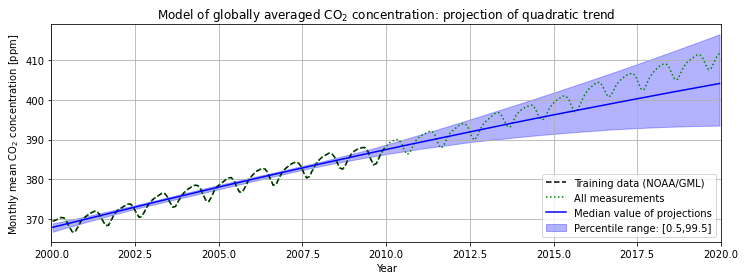

In [126]:
#.. define variables for projection and test
indPRJ = (Time >= RefYear) & (Time < RefYear+20)
TimePRJ = Time[indPRJ] - RefYear
DataPRJ = Data[indPRJ]
SampleSizePRJ = len(TimePRJ)
NumSamples = len(Aest0)
#.. compute quadratic trend projections, extract percentiles
QTrendCO2 = np.zeros((NumSamples,SampleSizePRJ))
for isamp in range(NumSamples):
    QTrendCO2[isamp,:] = np.polyval([Aest2[isamp],Aest1[isamp],Aest0[isamp]],TimePRJ)
QTrendCO2pct = np.percentile(QTrendCO2,[0.5,50,99.5],axis=0)
#.. open figure object, plot data and model
plt.figure(figsize=(12,4))
plt.plot(TimeTRN+RefYear,DataTRN,'k--',label='Training data (NOAA/GML)')
plt.plot(TimePRJ+RefYear,DataPRJ,'g:',label='All measurements')
plt.fill_between(TimePRJ+RefYear,QTrendCO2pct[0,:],QTrendCO2pct[2,:],\
                 color='blue',alpha=0.3,label='Percentile range: [0.5,99.5]')
plt.plot(TimePRJ+RefYear,QTrendCO2pct[1,:],'b-',label='Median value of projections')
plt.xlim([RefYear,RefYear+20])
plt.title(r'Model of globally averaged CO$_2$ concentration: projection of quadratic trend')
plt.xlabel('Year')
plt.ylabel(r'Monthly mean CO$_2$ concentration [ppm]')
plt.legend(loc=4)
plt.grid()
#... store figure in graphics file
plt.savefig(r'co2gl_qtproj_{b:4}-{e:4}.pdf'.format(b=RefYear,e=RefYear+20),\
            facecolor=None,bbox_inches='tight')

For these particular 10-year and 20-year periods, the projections agree reasonably well with the measurements. To see that projections can be much worse, repeat the modeling exercise with other choices of the reference year (1980,1985,1990,1995). As a further test of the projection procedure you may model the quadratic trend from the 20-year period 1980-2000 that then compare with all data from the 40-year period 1980-2020.

Standard deviations :  0.4031470535631109 0.18989213646277012 0.018888822719258506


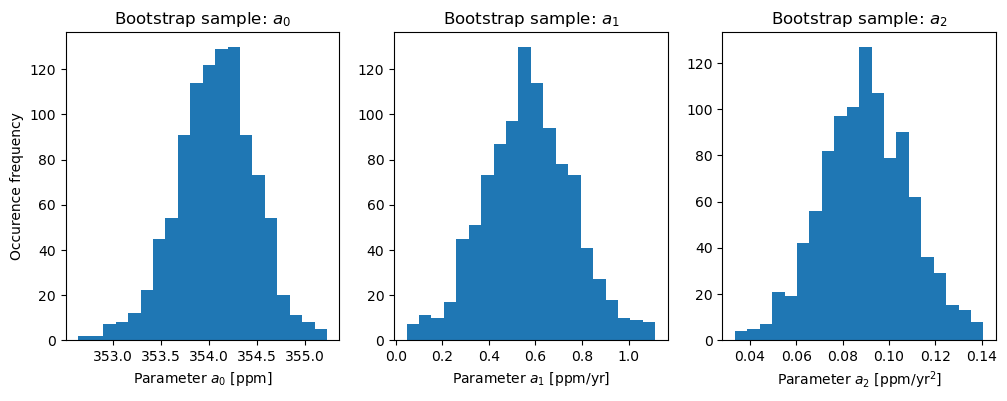

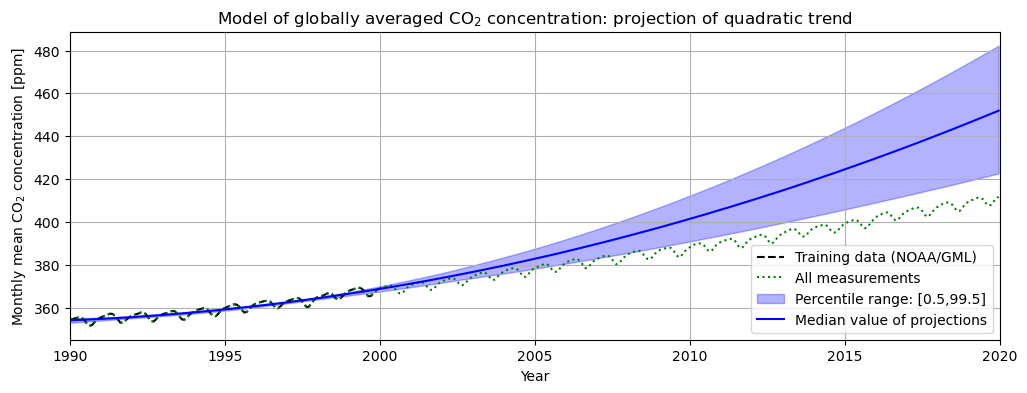

In [9]:
#.. bootstrap ensembles of quadratic trend coefficients

RefYear = 1990
indTRN = (Time >= RefYear) & (Time < RefYear+10)
TimeTRN = Time[indTRN] - RefYear
DataTRN = Data[indTRN]
Aest0,Aest1,Aest2 = QTrendCoeffBS(TimeTRN,DataTRN,FreqCO2)
print('Standard deviations : ',Aest0.std(),Aest1.std(),Aest2.std())

#.. histograms of quadratic trend coefficients

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(Aest0,20)
plt.title(r'Bootstrap sample: $a_0$')
plt.xlabel(r'Parameter $a_0$ [ppm]')
plt.ylabel('Occurence frequency')
plt.subplot(1,3,2)
plt.hist(Aest1,20)
plt.title(r'Bootstrap sample: $a_1$')
plt.xlabel(r'Parameter $a_1$ [ppm/yr]')
plt.subplot(1,3,3)
plt.hist(Aest2,20)
plt.title(r'Bootstrap sample: $a_2$')
plt.xlabel(r'Parameter $a_2$ [ppm/yr$^2$]')
#... store figure in graphics file
plt.savefig(r'co2gl_qthist_{b:4}-{e:4}.pdf'.format(b=RefYear,e=RefYear+20),\
            facecolor=None,bbox_inches='tight')

#.. plots of training data and test data

indPRJ = (Time >= RefYear) & (Time < RefYear+30)
TimePRJ = Time[indPRJ] - RefYear
DataPRJ = Data[indPRJ]
SampleSizePRJ = len(TimePRJ)
NumSamples = len(Aest0)

QTrendCO2 = np.zeros((NumSamples,SampleSizePRJ))
for isamp in range(NumSamples):
    QTrendCO2[isamp,:] = np.polyval([Aest2[isamp],Aest1[isamp],Aest0[isamp]],TimePRJ)
QTrendCO2pct = np.percentile(QTrendCO2,[0.5,50,99.5],axis=0)

plt.figure(figsize=(12,4))
plt.plot(TimeTRN+RefYear,DataTRN,'k--',label='Training data (NOAA/GML)')
plt.plot(TimePRJ+RefYear,DataPRJ,'g:',label='All measurements')
plt.fill_between(TimePRJ+RefYear,QTrendCO2pct[0,:],QTrendCO2pct[2,:],\
                 color='blue',alpha=0.3,label='Percentile range: [0.5,99.5]')
plt.plot(TimePRJ+RefYear,QTrendCO2pct[1,:],'b-',label='Median value of projections')
plt.xlim([RefYear,RefYear+30])
plt.title(r'Model of globally averaged CO$_2$ concentration: projection of quadratic trend')
plt.xlabel('Year')
plt.ylabel(r'Monthly mean CO$_2$ concentration [ppm]')
plt.legend(loc=4)
plt.grid()

plt.savefig(r'co2gl_qtproj_{b:4}-{e:4}.pdf'.format(b=RefYear,e=RefYear+30),\
            facecolor=None,bbox_inches='tight')

### Projection until 2060

Using data from the 40-year time period 1980-2020, construct projections for another 40 years until 2060. Start with constructing bootstrap ensembles of quadratic trend coefficients.

In [128]:
RefYear = 1980
indTRN = (Time >= RefYear) & (Time < RefYear + 40)
TimeTRN = Time[indTRN] - RefYear
DataTRN = Data[indTRN]
Aest0,Aest1,Aest2 = QTrendCoeffBS(TimeTRN,DataTRN,FreqCO2)
print(Aest0.std(),Aest1.std(),Aest2.std())
print(TimeTRN.shape)
print(np.arange(40,80,0.5).shape)

0.2065080622591728 0.024890946533053505 0.0006242218445264132
(480,)
(80,)


Display the boostrap distributions of the quadratic model parameters.

Text(0.5, 0, 'Parameter $a_2$ [ppm/yr$^2$]')

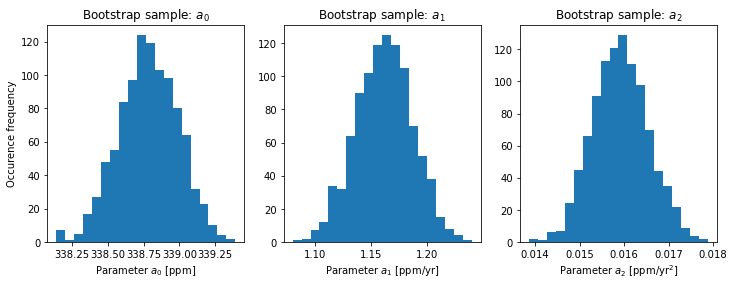

In [129]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(Aest0,20)
plt.title(r'Bootstrap sample: $a_0$')
plt.xlabel(r'Parameter $a_0$ [ppm]')
plt.ylabel('Occurence frequency')
plt.subplot(1,3,2)
plt.hist(Aest1,20)
plt.title(r'Bootstrap sample: $a_1$')
plt.xlabel(r'Parameter $a_1$ [ppm/yr]')
plt.subplot(1,3,3)
plt.hist(Aest2,20)
plt.title(r'Bootstrap sample: $a_2$')
plt.xlabel(r'Parameter $a_2$ [ppm/yr$^2$]')

From the bootstrap samples of quadratic trend coefficients construct the quadratic trend projections. Extract the percentiles and plot them as a function of time together with the training data.

(480,)
(1000, 960)


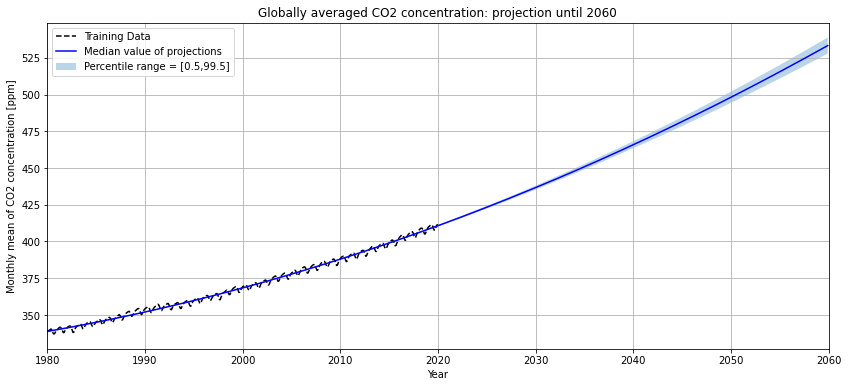

In [130]:
indPRJ = (Time >= RefYear) & (Time < RefYear + 80)
TimePRJ = np.arange(0,80,1/12)

NumSamples = len(Aest0)
SampleSize = len(TimePRJ)

QTrendCO2 = np.zeros((NumSamples,SampleSize))
for isamp in range(NumSamples):
    QTrendCO2[isamp,:] = np.polyval([Aest2[isamp],Aest1[isamp],Aest0[isamp]],TimePRJ)
QTrendCO2pct = np.percentile(QTrendCO2, [0.5,50,99.5], axis=0)
print(DataTRN.shape)
print(QTrendCO2.shape)
plt.figure(figsize=(14,6))
plt.plot(TimeTRN + RefYear, DataTRN,'k--',label='Training Data')
plt.plot(TimePRJ + RefYear, QTrendCO2pct[1,:],'b',label='Median value of projections')
plt.fill_between(TimePRJ+RefYear, QTrendCO2pct[0,:],QTrendCO2pct[2,:],alpha=0.3,label='Percentile range = [0.5,99.5]')
plt.title('Globally averaged CO2 concentration: projection until 2060')
plt.legend()
plt.grid()
plt.xlim([RefYear,RefYear+80])
plt.xlabel('Year')
plt.ylabel('Monthly mean of CO2 concentration [ppm]')
plt.savefig(r'co2gl_qtproj_{b:4}-{e:4}.pdf'.format(b=RefYear,e=RefYear+80),\
            facecolor=None,bbox_inches='tight')

Discuss the results in the light of the numerical experiments carried out before. Assuming that the processes not captured by the model are marine system variations on sub-decadal timescales, would you put more or less trust in this long-term projection?